# Processing of a single concrete CT image
## Prolog
**To be written**

## Imports

In [168]:
%load_ext autoreload
%autoreload 2
from functions import CTSlice, QuadraticBackgroundFunction
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import curve_fit

plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["figure.figsize"] = 12, 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load example slice

In [169]:
image_path = "./dummy_data/1_Probe1_0000,00_1600.png"
image_path = "/disk7102/home/kluwe/Schreibtisch/concrete_ct/images_obs/1_Probe1_0000,00_0922.png"

ct = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(400, 1900), y_crop=slice(300, 1800))
# function to update contour and pore mask based on binary operations
def update_masks(ct):
    ct.calc_contour_mask().dilate_contour_mask(
        iterations=5).erode_contour_mask(
            iterations=5).erode_contour_mask(
                iterations=8).calc_pore_mask(
                    ).dilate_contour_mask(
                    iterations=8)
                    
# function to only update the pore mask
def update_pore_mask(ct):
    ct.dilate_contour_mask(
        iterations=5).erode_contour_mask(
            iterations=5).erode_contour_mask(
                iterations=8).calc_pore_mask(
                    ).dilate_contour_mask(
                    iterations=8)
          
update_masks(ct)
print(ct)

-- CTSlice --
   size            : 1500 x 1500 | uint16
   min intensity   : 0
   max intensity   : 65535
   mean intensity  : 19758.524244
   median intensity: 23771.0
source: /disk7102/home/kluwe/Schreibtisch/concrete_ct/images_obs/1_Probe1_0000,00_0922.png


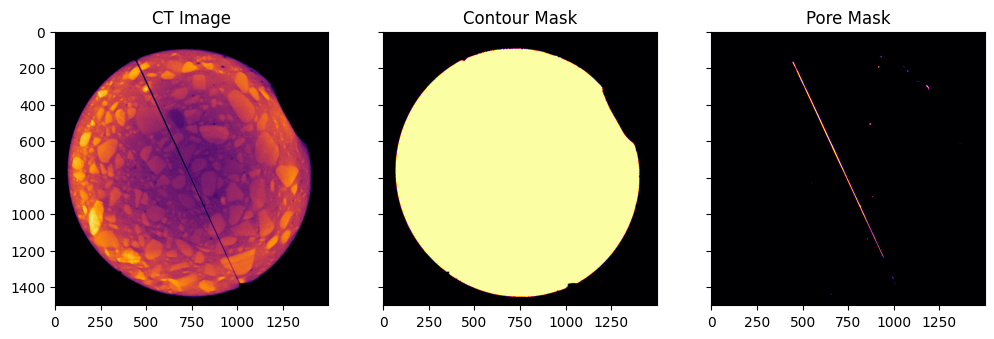

In [170]:
# show masks
fig, ax = plt.subplots(1, 3, sharey=True)

ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

## Centering the slice

In [171]:
method = "hough"
old_center = ct.get_center(method=method)
print(f"Old center: {old_center[0]:.2f}, {old_center[1]:.2f} | deviation from image center: {ct.width/2 - old_center[0]:.2f}, {ct.height/2 - old_center[1]:.2f}")
ct.center_slice(method=method)
update_masks(ct)
new_center = ct.get_center(method=method)
print(f"New center: {new_center[0]:.2f}, {new_center[1]:.2f} | deviation from image center: {ct.width/2 - new_center[0]:.2f}, {ct.height/2 - new_center[1]:.2f}")

Old center: 763.50, 757.50 | deviation from image center: -13.50, -7.50
New center: 749.50, 747.50 | deviation from image center: 0.50, 2.50


-- CTSlice --
   size            : 1500 x 1500 | uint16
   min intensity   : 0
   max intensity   : 65535
   mean intensity  : 19759.76711688889
   median intensity: 23768.0
source: /disk7102/home/kluwe/Schreibtisch/concrete_ct/images_obs/1_Probe1_0000,00_0922.png


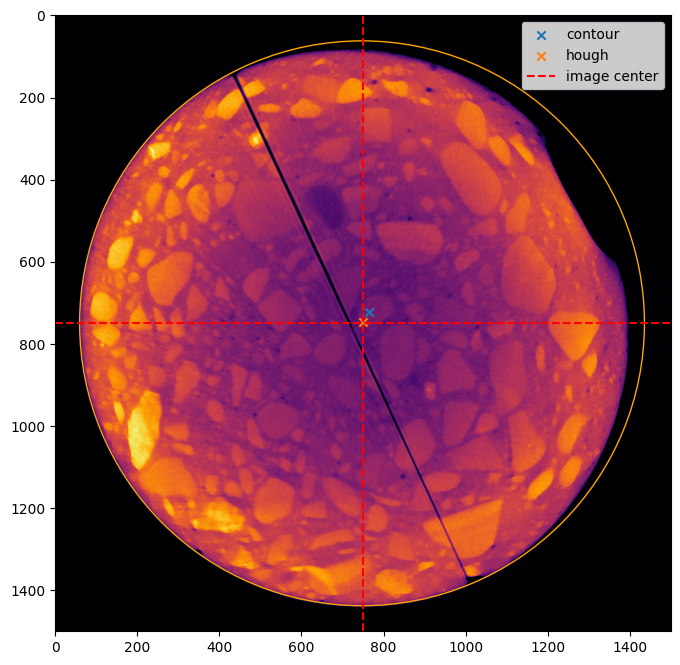

In [172]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()
ax.imshow(ct.image)

ax.scatter(*ct.get_center(), marker="x", label="contour")
ax.scatter(*ct.get_center(method="hough"), marker="x", label="hough")
ax.axvline(ct.width/2, c="r", ls="--", label="image center")
ax.axhline(ct.height/2, c="r", ls="--")

c = Circle(*ct.hough_transform(), fill=False, color="orange")
ax.add_artist(c)

ax.legend()
print(ct)

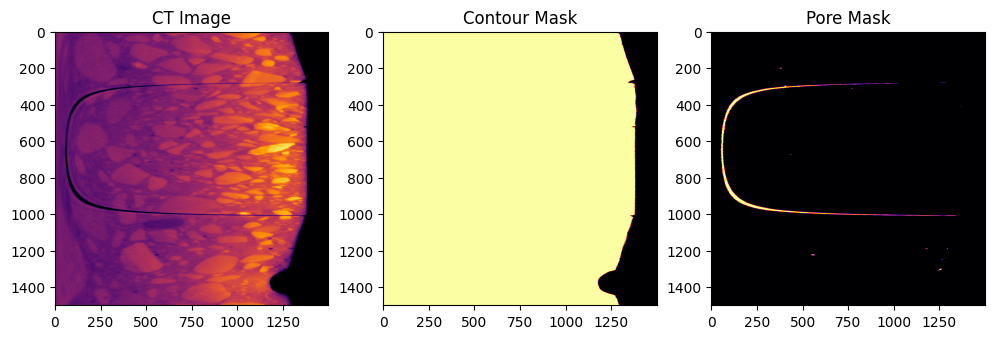

In [173]:
ct.transform(to="polar")

fig, ax = plt.subplots(1, 3)
ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

## Approximating the contour

Since the contour is closed a periodic function is used for the contour approximation. A cropped sine seems to approximate the contour very well.


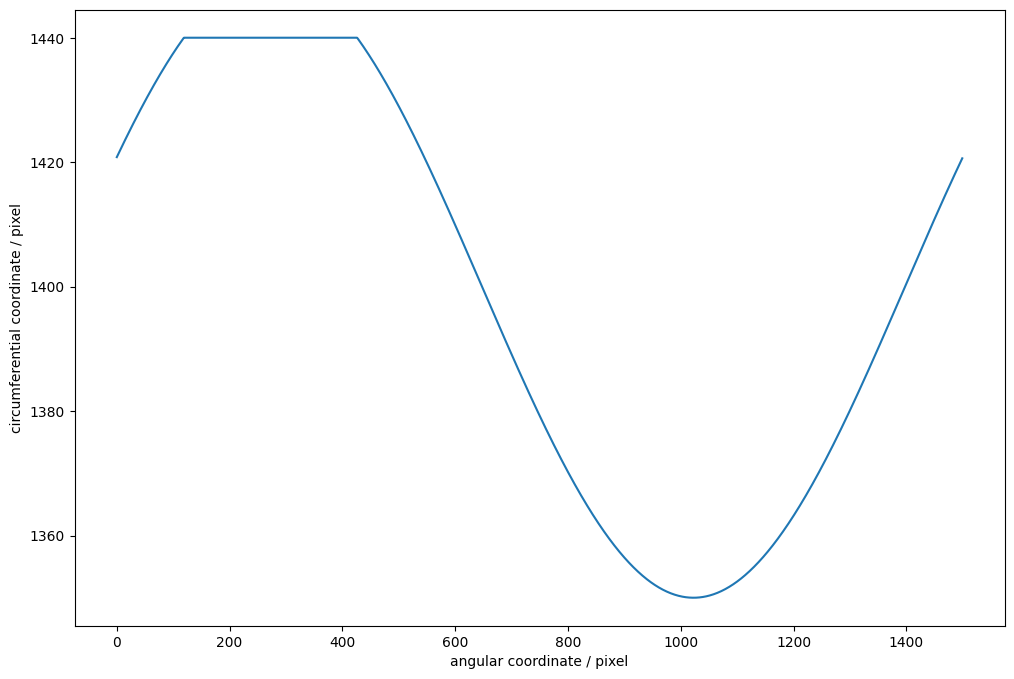

In [174]:
def sine_function(x, y0, ymax, a, b):
    sine = y0 + a * np.sin(1*np.pi*x / ct.width + b)**2
    sine[np.where(sine > ymax)] = ymax
    return sine 

x = np.arange(ct.width)

fig, ax = plt.subplots()
ax.set_xlabel("angular coordinate / pixel")
ax.set_ylabel("circumferential coordinate / pixel")
ax.plot(x, sine_function(x, 0.9 * ct.width, 1440, 100, 1))

A threshold is used to exclude the deep dip from the fit. The threshold is currently defined using `np.percentil`. Maybe this can optimized in future.

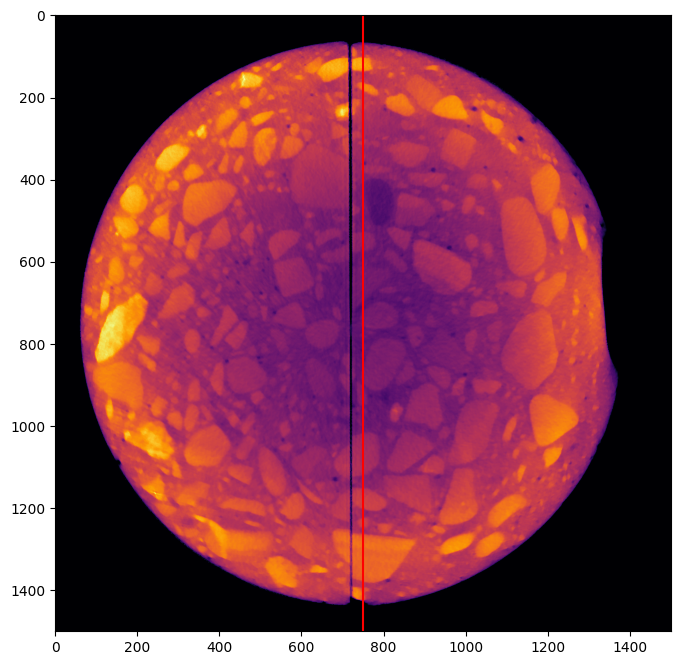

In [175]:
ct.transform(to="polar")

roll = 103

ct.image = np.roll(ct.image, roll, axis=0)
ct.contour_mask = np.roll(ct.contour_mask, roll, axis=0)
ct.pore_mask = np.roll(ct.pore_mask, roll, axis=0)

ct.transform(to="linear")
plt.imshow(ct.image)
plt.axvline(750, c="r")

array([1479.23822292, 1380.26450742, -201.75346107,    1.59985869])

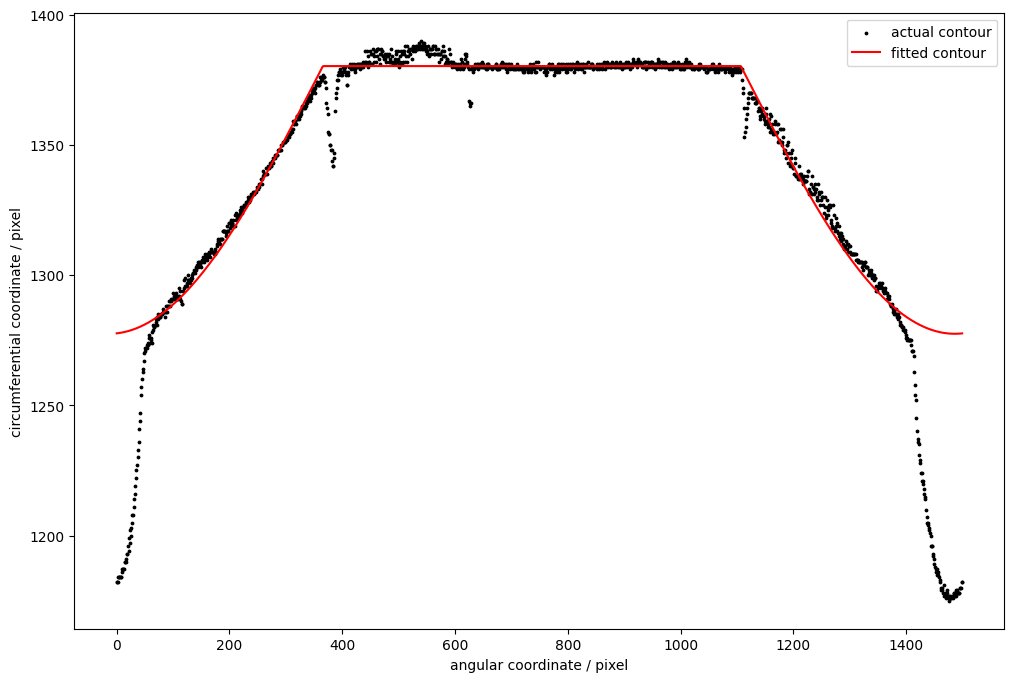

In [176]:
ct.transform(to="polar")
np.roll(ct.image, 10, axis=1)
    
contour = np.argmin(ct.contour_mask, axis=1)

fit_thresh = np.percentile(contour, 8)
contour_max = np.max(contour)
contour_median = np.median(contour)
popt, pcov = curve_fit(
    sine_function, 
    x[np.where(contour > fit_thresh)], 
    contour[np.where(contour > fit_thresh)],
    p0=[contour_median, contour_max, contour_median - contour_max, 1],
    )

fig, ax = plt.subplots()
ax.set_xlabel("angular coordinate / pixel")
ax.set_ylabel("circumferential coordinate / pixel")
ax.scatter(x, contour, c="k", s=3, label="actual contour")
ax.plot(x, sine_function(x, *popt), c="r", label="fitted contour")
ax.legend()
popt

## Correct circulartity

Using the approximated contour the image can be manipulated row wise to fit a circle in polar space. Subsequnetly the contour mask is adjusted in polar space because sometimes holes arise after the transformation to linear (cartesian) space.

In [177]:
ct.correct_circularity(np.rint(sine_function(x, *popt)).astype(int))
ct.transform(to="linear")
update_masks(ct)
update_pore_mask(ct)
ct.transform(to="polar")
ct.contour_mask[:, :1000] = 1

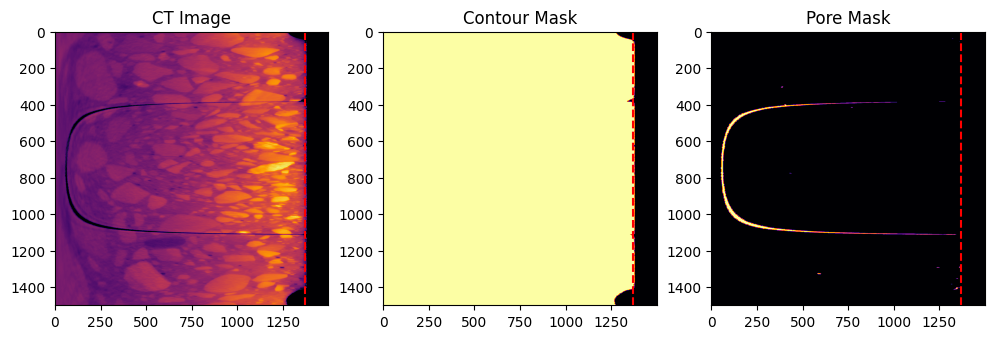

In [178]:
ct.transform(to="polar")

fig, ax = plt.subplots(1, 3)
ax[0].set_title("CT Image")
ax[0].imshow(ct.image)
ax[1].set_title("Contour Mask")
ax[1].imshow(ct.contour_mask)
ax[2].set_title("Pore Mask")
ax[2].imshow(ct.pore_mask)

for axes in ax:
    axes.axvline(np.ceil(np.median(contour)), c="r", ls="--")

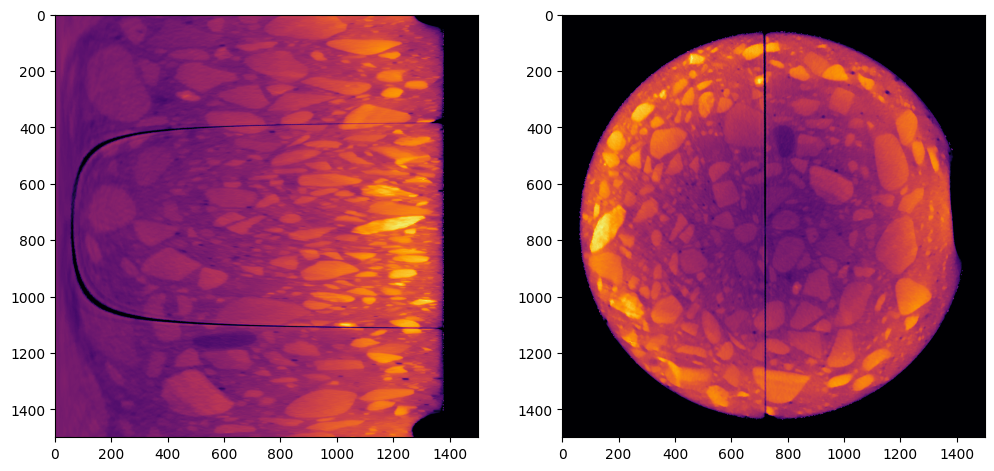

In [179]:
fig, ax = plt.subplots(1, 2)
ct.transform(to="polar")
ax[0].imshow(ct.image)
ct.transform(to="linear")
ax[1].imshow(ct.image)

## Intensity correction

The intensity correction is perfommed by fitting a generic intensity profile to the mean intensity of the image in polar space. Afterwards the circumferential axis is divided by this mean intensity profile which evens out the intensity distribution.

/disk7102/home/kluwe/GitRepos/CT_edge_hardening_remover/functions.py:151: RuntimeWarning: invalid value encountered in power
  lambda x, x0, a, b, c, d, e: a + b * x + c * x**2 - d ** ((x - x0) / e)


(0.0, 65000.0)

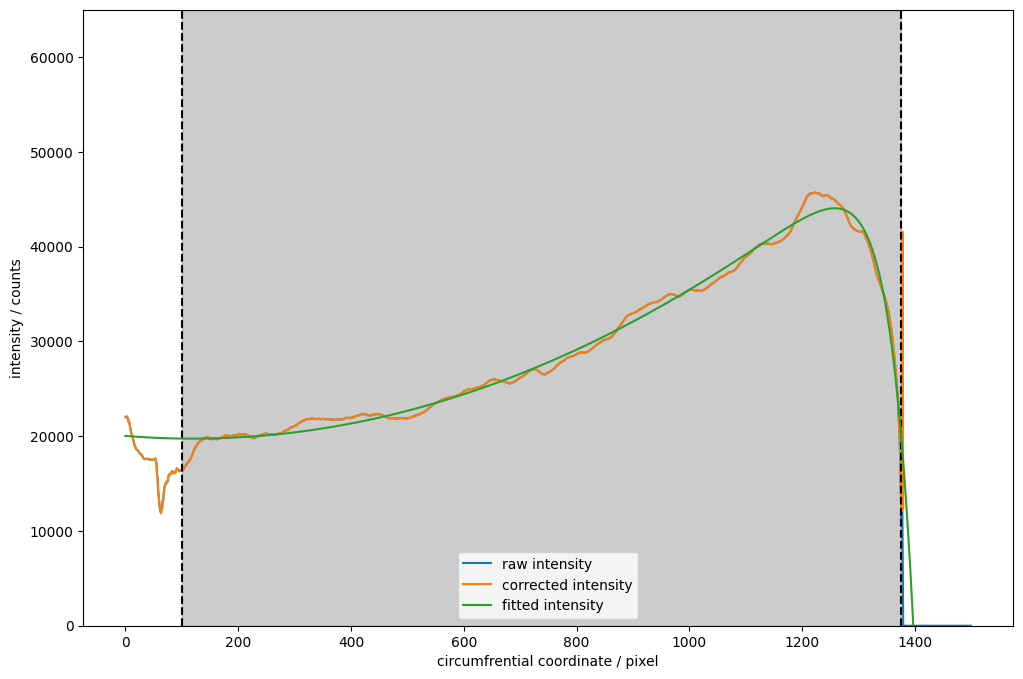

In [182]:
from functions import QuadraticExponentialBackgroundFunction

ct.transform(to="polar")
fig, ax = plt.subplots()
ax.set_xlabel("circumfrential coordinate / pixel")
ax.set_ylabel("intensity / counts")

ax.plot(ct.image[400:1000, :].mean(axis=0), label="raw intensity")

# create a temporary image where pores are filled with median value
tmp_img = ct.image.copy().astype(np.float64)
tmp_img = np.ma.array(tmp_img, mask=~ct.contour_mask.astype(np.bool_))

# tmp_img[ct.pore_mask] = ct.median
ax.plot(np.mean(tmp_img[400:1000, :], axis=0), label="corrected intensity")

# fit intensity profile
x_min = 100
x_max = 1375
for x in [x_min, x_max]:
    ax.axvline(x, ls="--", c="k")
ax.axvspan(x_min, x_max, color="k", alpha=0.2)

# quad = QuadraticBackgroundFunction()
quad = QuadraticExponentialBackgroundFunction()
quad.fit(
     np.arange(x_min, x_max),
     tmp_img[400:1000, :].mean(axis=0)[x_min:x_max],
     p0=[1000, 20000, 2, 0.01, 0.8, -9.4]
     )
# quad.fit(
#      np.arange(x_min, x_max),
#      tmp_img.mean(axis=0)[x_min:x_max])

ax.plot(quad.eval(np.arange(ct.width)), label="fitted intensity")
# ax.plot(quad.eval_params(np.arange(ct.width), 1000, 20000, 2, 0.01, 0.8, -9.4))
ax.legend()
ax.set_ylim(0, 65000)

In [183]:
# correct image
f = quad.eval(np.arange(ct.width))
# image = ct.image.copy() / ((f/f.max()))
image = ct.image.copy().astype(np.float64) / f
mean, std = image.mean(), image.std()
image = image - mean
image = image * (std / 0.3)
image = image + 0.5
# convert to uint16
image = (np.clip(image, 0, 1) * np.iinfo(np.uint16).max).astype(np.uint16) 

# over write current ct image
ct.image = image

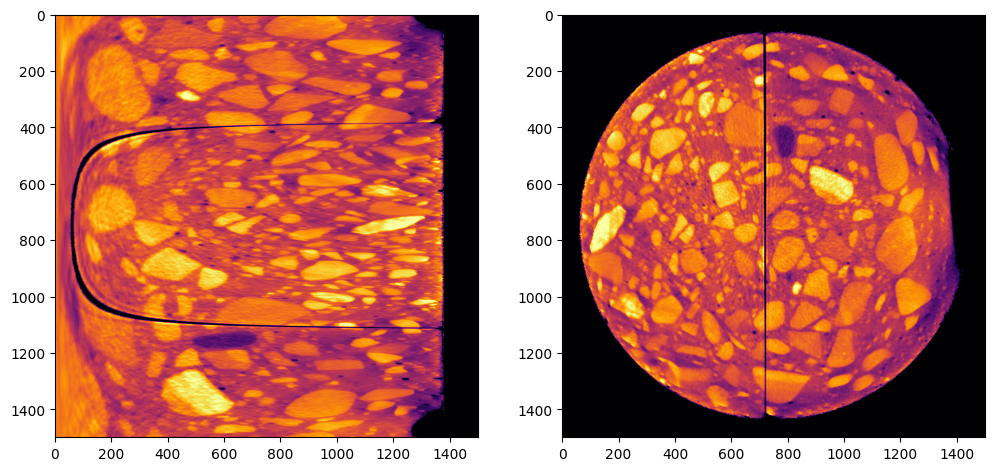

In [184]:
fig, ax = plt.subplots(1, 2)
ct.transform(to="polar")
ax[0].imshow(ct.image)
ct.transform(to="linear")
ax[1].imshow(ct.image)

## Final result

Comparing the raw image to the processed one.

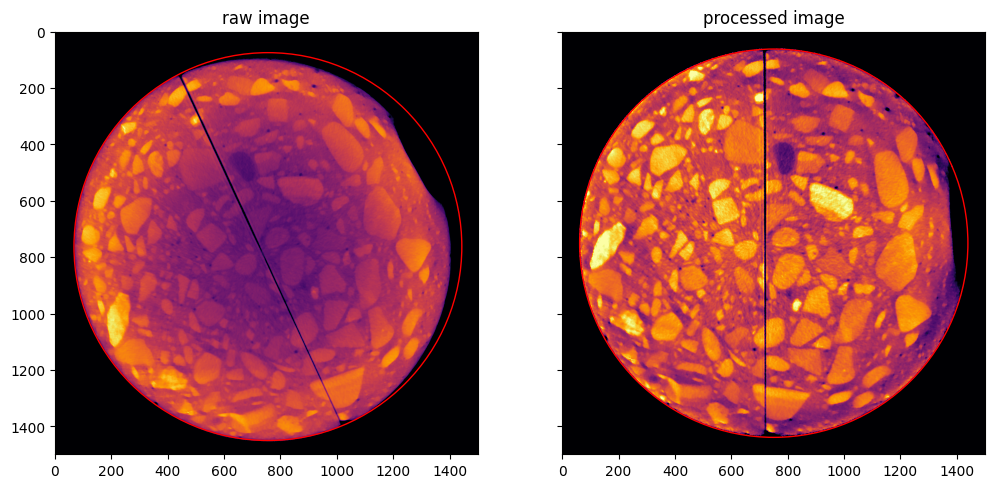

In [185]:
from matplotlib.patches import Circle

ct_raw = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(400, 1900), y_crop=slice(300, 1800))
fig, ax = plt.subplots(1, 2, sharey=True)
ax[0].set_title("raw image")
ax[0].imshow(ct_raw.image)
c = Circle(*ct_raw.hough_transform(), fill=False, color="red")
ax[0].add_artist(c)

ct.transform(to="linear")
ax[1].set_title("processed image")
ax[1].imshow(ct.image)
c = Circle(*ct.hough_transform(), fill=False, color="red")
ax[1].add_artist(c)

## Stack Processing

In [189]:
from pathlib import Path
from tqdm.notebook import tqdm
from skimage.exposure import match_histograms
from copy import deepcopy

image_dir = Path("/disk7102/home/kluwe/Schreibtisch/concrete_ct/images_obs")
save_dir = Path("/disk7102/home/kluwe/Schreibtisch/concrete_ct/processed_v2/")

save_dir.mkdir(exist_ok=True)

image_paths = sorted(image_dir.glob("*.png"))

centering_method = "hough"

# background fit parameter
x_min = 100
x_max = 1375
background_function = QuadraticBackgroundFunction()
background_function = QuadraticExponentialBackgroundFunction()

shift = None
reference = None

def image_to_float(image):
    image = image - image.min()
    image = image / image.max()
    return image

shift = None
for image_path in tqdm(image_paths):
    ct = CTSlice.import_cv2(image_path, cv2.IMREAD_ANYDEPTH, x_crop=slice(400, 1900), y_crop=slice(300, 1800))
    update_masks(ct)
    # center the slice 
    if shift is None:
        shift = ct.get_shift(method=centering_method)
    ct.shift_image(*shift)
    center = ct.get_center(method=centering_method)   
    # ct.center_slice(method=centering_method)
    update_masks(ct)
    # fit the contour
    ct.transform(center=center, to="polar")
    roll = 103

    ct.image = np.roll(ct.image, roll, axis=0)
    ct.contour_mask = np.roll(ct.contour_mask, roll, axis=0)
    ct.pore_mask = np.roll(ct.pore_mask, roll, axis=0)

    contour = np.argmin(ct.contour_mask, axis=1)
    fit_thresh = np.percentile(contour, 8)
    x = np.arange(ct.width)
    contour_max = np.max(contour)
    contour_median = np.median(contour)
    popt, pcov = curve_fit(
    sine_function, 
    x[np.where(contour > fit_thresh)], 
    contour[np.where(contour > fit_thresh)],
    p0=[contour_median, contour_max, contour_median - contour_max, 1],
    )
    # correct circularity
    ct.correct_circularity(
        np.rint(sine_function(x, *popt)).astype(int),
        goal_length=1380)
    ct.transform(center=center, to="linear")
    update_masks(ct)
    update_pore_mask(ct)
    ct.transform(center=center, to="polar")
    ct.contour_mask[:, :1000] = 1
    tmp_img = ct.image.copy()
    tmp_img = np.ma.array(tmp_img, mask=~ct.contour_mask.astype(np.bool_), fill_value=0)
    # background_function.fit(np.arange(x_min, x_max), tmp_img.mean(axis=0)[x_min:x_max])
    background_function.fit(
        np.arange(x_min, x_max),
        tmp_img[400:1000, :].mean(axis=0)[x_min:x_max],
        p0=[1000, 20000, 2, 0.01, 0.8, -9.4]
        )
    # correct image first iter quadratic
    f = background_function.eval(np.arange(ct.width))
    image = tmp_img.astype(np.float64) / f
    # image -= image.min()
    # image /= image.max()
    # equalize brightness
    mean, std = image.mean(), image.std()
    image = image - mean
    image = image * (std / 0.3)
    image = image + 0.5
    # convert to uint16
    image = (np.clip(image, 0, 1) * np.iinfo(np.uint16).max).astype(np.uint16) 
    # over write current ct image
    ct.image = image.data
    # update_masks(ct)
    
    ct.transform(center=center, to="linear")
    # if reference is None:
    #     reference = ct.image
    # matched = match_histograms(ct.image, reference).astype(np.uint16)
    # matched = (image_to_float(matched) * np.iinfo(np.uint16).max).astype(np.uint16)
    cv2.imwrite(
        str(save_dir.joinpath(image_path.name)),
        ct.image
        )


  0%|          | 0/1001 [00:00<?, ?it/s]

/disk7102/home/kluwe/GitRepos/CT_edge_hardening_remover/functions.py:151: RuntimeWarning: invalid value encountered in power
  lambda x, x0, a, b, c, d, e: a + b * x + c * x**2 - d ** ((x - x0) / e)


In [187]:
image_paths = sorted(save_dir.glob("*.png"))

stack = np.zeros((len(image_paths), 1500, 1500))

for i, image_path in enumerate(tqdm(image_paths)):
    stack[i] = cv2.imread(str(image_path), cv2.IMREAD_ANYDEPTH)


  0%|          | 0/1001 [00:00<?, ?it/s]

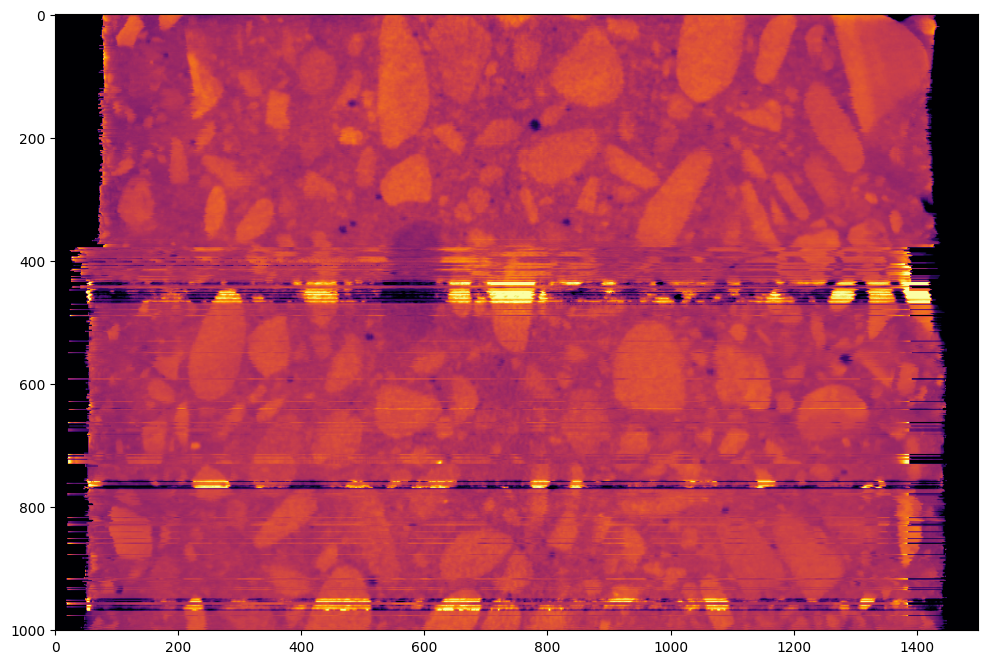

In [188]:
plt.imshow(stack[:, :, 750])

True

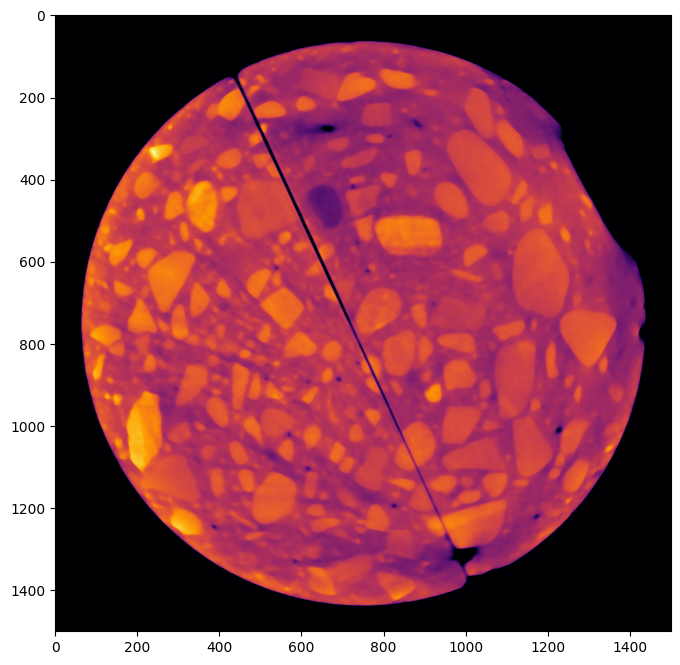

In [38]:
from scipy.ndimage import median_filter

smoothed_image = median_filter(stack[:10, :, :], 10)[5,:,:]

plt.imshow(smoothed_image)

In [40]:
cv2.imwrite("tmp.png", smoothed_image.astype(np.uint16))

True

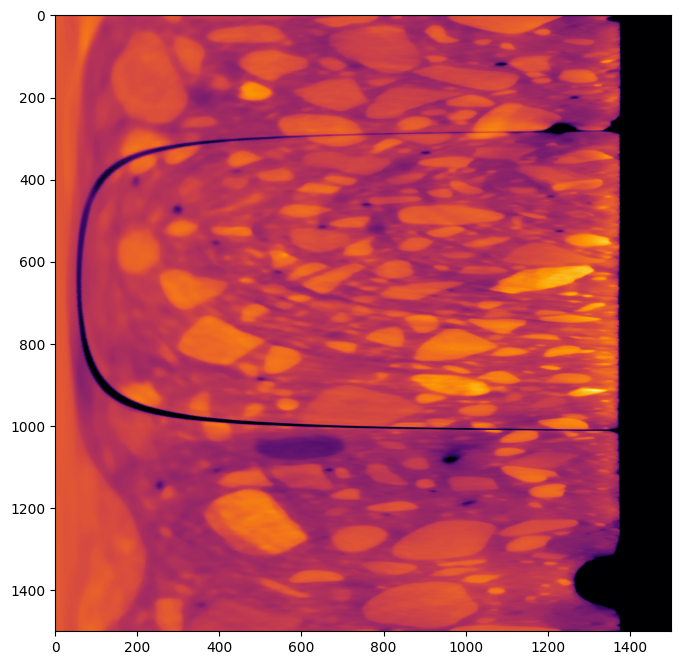

In [45]:
polar = cv2.linearPolar(
                smoothed_image.astype(np.uint16), (750, 750), 750, cv2.WARP_FILL_OUTLIERS
            )

plt.imshow(polar)

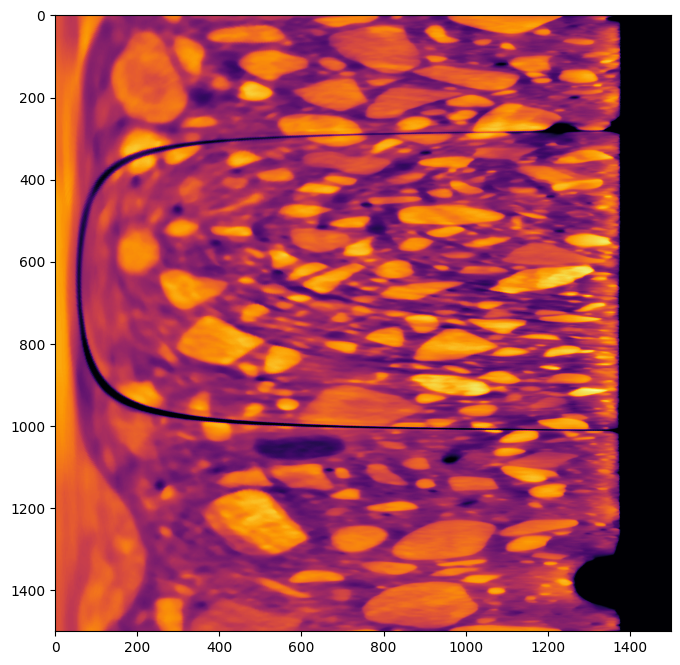

In [48]:
from skimage import exposure
polar_expo = exposure.equalize_adapthist(polar, 101)
plt.imshow(polar_expo)

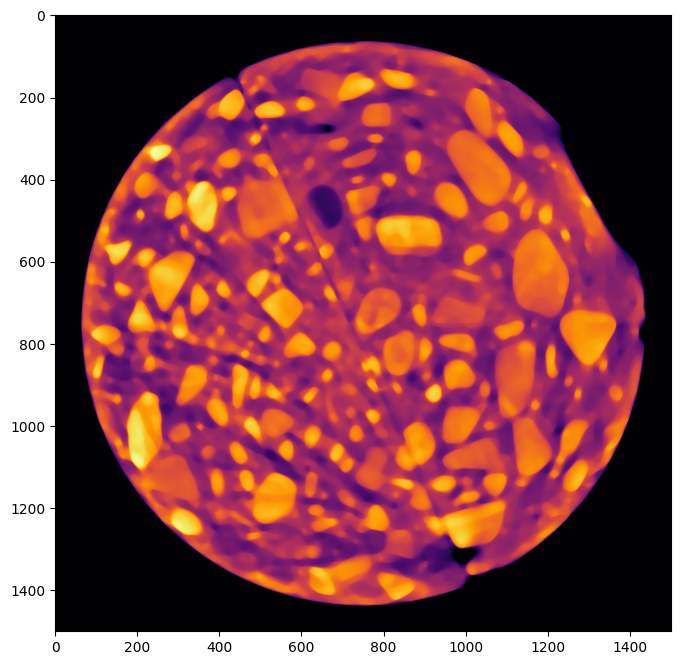

In [57]:
unpolar = cv2.linearPolar(
                polar_expo, (750, 750), 750, cv2.WARP_FILL_OUTLIERS + cv2.WARP_INVERSE_MAP
            )
unpolar = median_filter(unpolar, 21)
plt.imshow(unpolar)

In [58]:
from skimage.util import img_as_uint

cv2.imwrite("tmp.png", img_as_uint(unpolar))

True

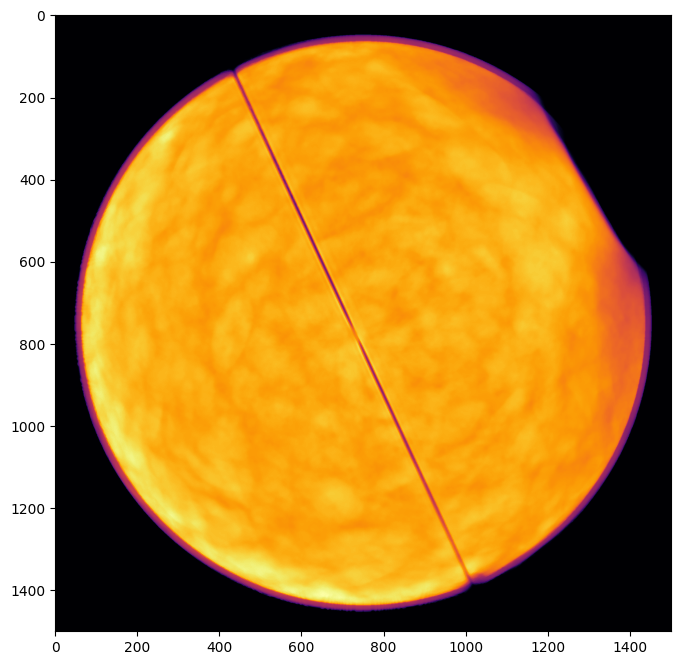

In [25]:
mean_image = median_filter(stack.mean(axis=0), 5)
plt.imshow(mean_image)

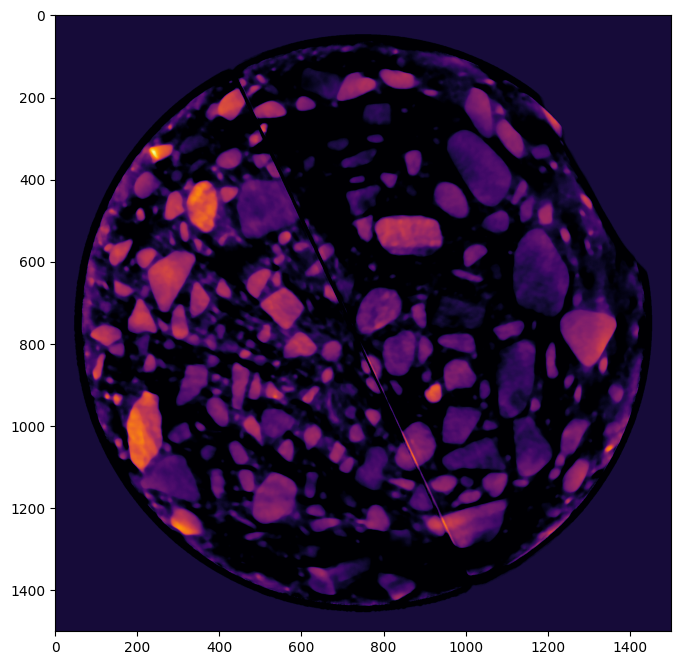

In [37]:
from skimage import filters
from skimage.morphology import square

footprint = square(5)

plt.imshow(
        np.clip(
        smoothed_image - filters.median(mean_image, footprint),
        -3000,
        40000
        )
    )